In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from numpy.random import seed
import glob
import re
from scipy.special import softmax

#  DATA

### --pCut::Motor_Torque -> Torque in nM

### --pCut::CTRL_Position_controller::Lag_error -> Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor

### --pCut::CTRL_Position_controller::Actual_position -> Cutting blade position in mm

### --pCut::CTRL_Position_controller::Actual_speed -> Speed of the cutting blade

### --pSvolFilm::CTRL_Position_controller::Actual_position -> Plastic film unwinder position in mm

### --pSvolFilm::CTRL_Position_controller::Actual_speed -> Speed of the plastic film unwinder

### --pSvolFilm::CTRL_Position_controller::Lag_error -> Represent the instantaneous position error between the set-point from the path generator and the real current encoder position of the motor

### --pSpintor::VAX_speed -> VAX measurement of performance


**First things first, we have info on the samples that aren't in our sample csv files. Also, all our samples are separated in different files. So we will compile it all together to get a big dataframe with everything we need.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path=r'/content/drive/MyDrive/python code'
all_files = glob.glob(path + "/*.csv")
print (len(all_files))
data=[]
for i in all_files:
    
    #taking the unique mode value for example there are 8 mode so my dataframe will contain mode number to which that data point belong 
    file=re.split("_",i)
    mode=re.split(".csv",file[2])
    mode=re.search("[0-9]",mode[0])
    
    #taking all the unique sample values i.e 519 and datapoint will have respective sample no in dataframe 
    sample=re.split(".csv",file[1])
    
    #creating a dataframe 
    dataframe=pd.read_csv(i)
    dataframe["mode"]=mode.group(0)
    dataframe["sample"]=sample[0].lstrip("0")
    
    #appending it to the list 
    data.append(dataframe)
    
#concating a list to get final whole dataframe     
main_df=pd.concat(data,ignore_index=True)
print (main_df.shape)

519
(1062912, 11)


In [ ]:
# for taking sample no 0 
def sample_edit(data):
        return "0"
main_df["sample"].loc[0:2048]=main_df["sample"].head(2048).apply(sample_edit)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Lets see distribution of datapoints with respect to mode

In [ ]:
main_df["mode"].value_counts()

1    468992
2    247808
3    143360
5    122880
6     36864
4     24576
8     12288
7      6144
Name: mode, dtype: int64

Lets see distribution of sample with respect to mode 

In [ ]:

main_df.groupby(["sample","mode"]).size().groupby("mode").count()

mode
1    229
2    121
3     70
4     12
5     60
6     18
7      3
8      6
dtype: int64

In [ ]:
main_df["sample"].nunique()

519

**Now that we have the saved file we won't need to run those functions again. Let's look into our main dataframe**

In [ ]:
main_df.describe()

,timestamp,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed
count,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06,1.062912e+06
mean,4.102069e+00,-1.206338e-01,-5.472746e-05,3.371415e+08,1.945795e+03,1.488169e+08,5.367032e+03,9.847591e-01,1.927328e+03
std,2.364827e+00,6.078708e-01,1.212122e-01,5.466868e+08,4.873922e+03,2.711355e+08,3.382194e+03,3.437204e-01,6.559047e+02
min,4.000000e-03,-6.560303e+00,-1.888258e+00,-2.039056e+09,-9.482574e+03,1.936250e+05,-2.013385e+01,-9.143658e-01,0.000000e+00
25%,2.056000e+00,-3.696310e-01,-2.201461e-02,8.626082e+07,-1.908875e+03,2.136702e+07,3.032669e+03,8.384416e-01,1.500000e+03
50%,4.104000e+00,-1.187128e-01,6.456900e-04,1.919407e+08,2.595520e+03,7.259557e+07,4.582979e+03,9.711797e-01,1.800000e+03
75%,6.152000e+00,2.546913e-01,2.380830e-02,5.691639e+08,5.441666e+03,1.602507e+08,5.823731e+03,1.105926e+00,2.280000e+03
max,8.199999e+00,3.856873e+00,2.021531e+00,1.911789e+09,1.792831e+04,1.453671e+09,1.797202e+04,3.567880e+00,3.600000e+03


**Let's look for correlation between data. 

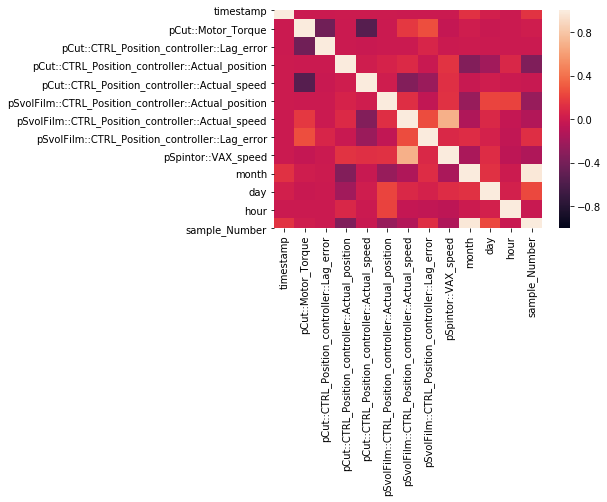

In [ ]:
#heatmap of correlations from -1 to 1
sns.heatmap(main_df.corr(), vmin= -1, vmax = 1)

**Lets drop some columns and flip our motor torque column values by multiplying it by -1. Just for some more visual understanding**

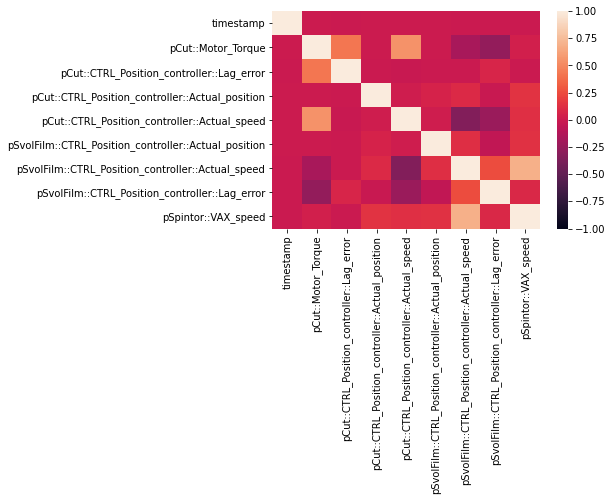

In [ ]:

#Flipping column values
main_df['pCut::Motor_Torque'] = main_df['pCut::Motor_Torque'] *-1
#Heatmap
sns.heatmap(main_df.corr(), vmin= -1, vmax = 1)


## Treating non-numerical data

**In our dataset, the modes for the machine may influence in data patterns, so we need to transform that data from string to numerical classes. This function will do just that.** 

In [ ]:
def handle_non_numeric(df):
    # Values in each column for each column
    columns = df.columns.values
    
    for column in columns:
        
        # Dictionary with each numerical value for each text
        text_digit_vals = {}
        
        # Receives text to convert to a number
        def convert_to_int (val):
            
            # Returns respective numerical value for class
            return text_digit_vals[val]
        
        # If values in columns are not float or int
        if df[column].dtype !=np.int64 and df[column].dtype != np.float64:
            
            # Gets values form current column
            column_contents = df[column].values.tolist()
            
            # Gets unique values from current column
            unique_elements = set(column_contents)
            
            # Classification starts at 0
            x=0
            
            for unique in unique_elements:
                
                # Adds the class value for the text in dictionary, if it's not there
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1
            
            # Maps the numerical values to the text values in columns 
            df[column] = list(map(convert_to_int, df[column]))
    
    return df

# Approach

**A few algorithms will be ested to see if we can get some info on the machine. We will use OneClass SVM and KMeans with 1 cluster to try clustering. After that we will try an Autoencoder to try and reproduce data based on the machines healthy condition.**

**In all 3 cases we will grab a slice of the first rows and consider it as the Healthy State of the machine, then feed it to the algorithms. After that we will give the algorithms the entirety of the dataset and see how they perform on the rest of the data. Deviations, low socres, and high losses will be considered as anomalies to be studied.**

# OneClass SVM approach

**OneClass SVM is used for outlier detection, it tries to find 2 classes in the data, the "normal" class and the outliers. We will use the SVM to try and find outliers and anomalies.**

In [ ]:
#Transforming modes into classified data
main_df = handle_non_numeric(main_df)

#Passing our dataframe as our features
X = main_df

#Defining preprocessor for the data
scaler = preprocessing.MinMaxScaler()
#Preprocessing
X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)


#Scaling
X = preprocessing.scale(X)
#Splitting the feature data for training data. First 200.000 rows.
X_train = X[:200000]


#Creating a fitting OneClass SVM
ocsvm = OneClassSVM(nu=0.25, gamma=0.05)
ocsvm.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.05, kernel='rbf',
            max_iter=-1, nu=0.25, shrinking=True, tol=0.001, verbose=False)

**Predicting and classifying the dataset in anomalies and non-anomalies, then passing it to a dataframe.**

In [ ]:


df=main_df.copy()
df['anomaly'] = pd.Series(ocsvm.predict(X))



**Reading into dataframe**

In [ ]:
df.head()

,pCut::Motor_Torque,pCut::CTRL_Position_controller::Lag_error,pCut::CTRL_Position_controller::Actual_position,pCut::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Actual_position,pSvolFilm::CTRL_Position_controller::Actual_speed,pSvolFilm::CTRL_Position_controller::Lag_error,pSpintor::VAX_speed,mode,anomaly
0,0.199603,0.027420,628392628,-920.104980,5298555,2441.235352,0.899543,1379.999756,2,1
1,0.281624,0.002502,628392625,-937.271118,5298565,2453.819092,0.874072,1379.999756,2,1
2,0.349315,-0.018085,628392621,-951.004028,5298575,2476.469727,0.879806,1379.999756,2,1
3,0.444450,-0.054680,628392617,-1019.668579,5298585,2501.637207,0.837500,1379.999756,2,1
4,0.480923,-0.042770,628392613,-1023.101807,5298595,2519.254395,0.905347,1379.999756,2,1


**Visualizing anomalies**

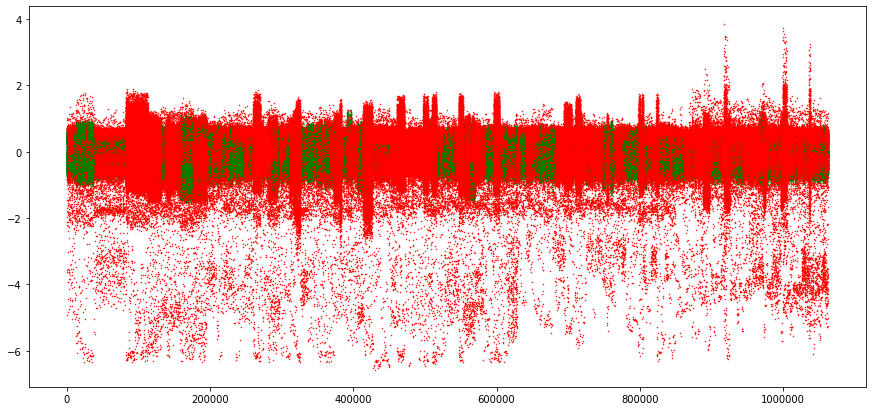

In [ ]:
#Getting labled groups
scat_1 = df.groupby('anomaly').get_group(1)
scat_0 = df.groupby('anomaly').get_group(-1)

# Plot size
plt.subplots(figsize=(15,7))

# Plot group 1 -labeled, color green, point size 1
plt.plot(scat_1.index,scat_1['pCut::Motor_Torque'], 'g.', markersize=1)

# Plot group -1 -labeled, color red, point size 1
plt.plot(scat_0.index, scat_0['pCut::Motor_Torque'],'r.', markersize=1)


**Visualizing scores for the whole dataset**

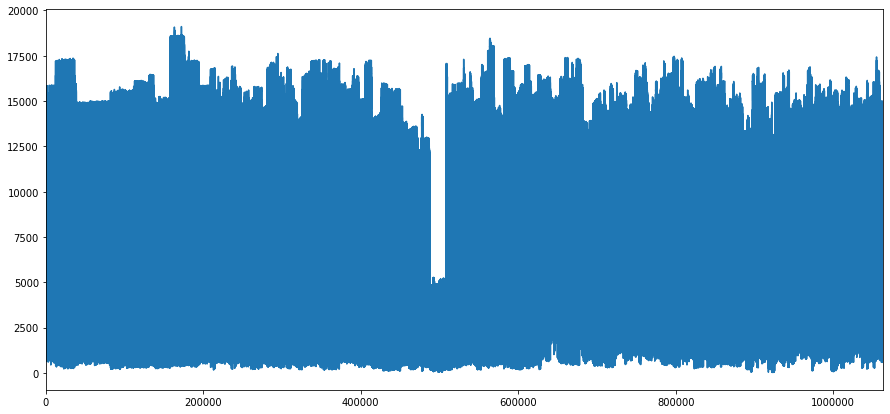

In [ ]:
#Creating a dataframe for the score of each data sample
score = pd.DataFrame()
#Returning scores for the dataset
score['score'] = ocsvm.score_samples(X)

#Plot size
plt.subplots(figsize=(15,7))
#Plotting
score['score'].plot()
#Saving score dataframe
score.to_csv('compiled_df//SVM_Score.csv')

**Inverted score moving mean**

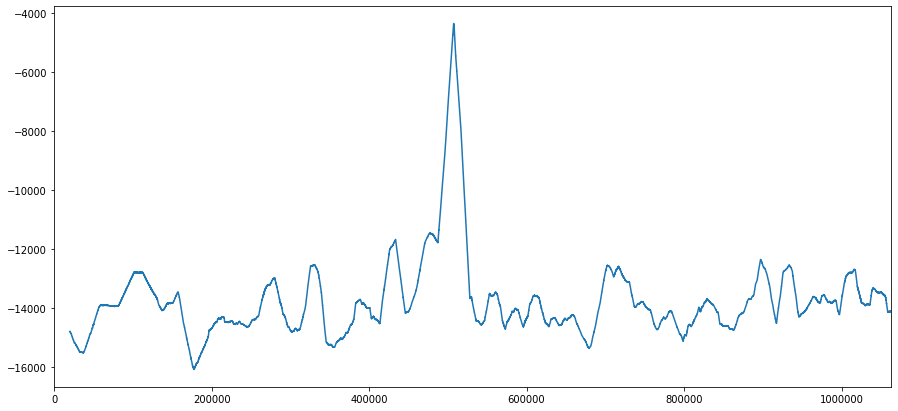

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))


((score['score'].rolling(20000).mean())*-1).plot(ax=ax)

**Scat plot to see the score through the noise**

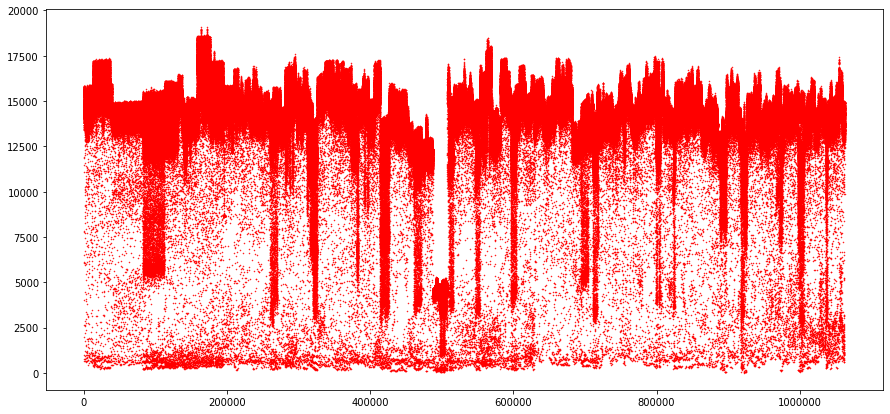

In [ ]:
plt.subplots(figsize=(15,7))
plt.plot(score.index, score['score'],'r.', markersize=1)

# KMeans approach

**Kmeans approach will do the same thing as the OC-SVM**

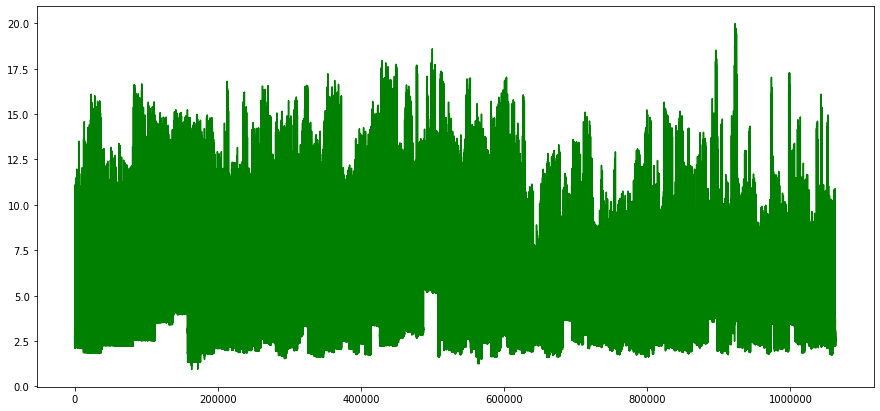

In [ ]:
#------ Preparing features for training and future prediction -----
main_df = pd.read_csv('compiled_df//One_year_compiled.csv')
main_df = main_df.drop(['day', 'hour', 'sample_Number', 'month', 'timestamp'], axis=1)
main_df = handle_non_numeric(main_df)
X = main_df

scaler = preprocessing.MinMaxScaler()

X = pd.DataFrame(scaler.fit_transform(X), 
                              columns=X.columns, 
                              index=X.index)



X = preprocessing.scale(X)
#-------------------------------------------------------------------


#Percentage of the data that will be considered healthy condition
train_percentage = 0.15
#Integer value for the slice that will be considered healthy condition
train_size = int(len(main_df.index)*train_percentage)
#Grabbing slice for training data
X_train = X[:train_size]


#Defining KMeans with 1 cluster
kmeans = KMeans(n_clusters=1)
#Fitting the algorithm
kmeans.fit(X_train)

#Creating a copy of the main dataset
k_anomaly = main_df.copy()

#Dataframe now will receive the distance of each data sample from the cluster
k_anomaly = pd.DataFrame(kmeans.transform(X))

#Saving cluster distane into csv file
k_anomaly.to_csv('compiled_df//KM_Distance.csv')

#Plot
plt.subplots(figsize=(15,7))

plt.plot(k_anomaly.index, k_anomaly[0], 'g', markersize=1)

# Conclusion 

**With all the info gathered we could tell where and when the machine suffered massive degradation. We could also tell which of the measurments contributes more to the loss on the whole year of the machine, which tells us these components made need more attention. Percentile thresholds, Distribution anomaly analyses, SVMs and much more other methods can be used for the detection of component wear over time with the info given here.**

**A problem with this method is the need to preprocess and scale data entirely to be then given to the algorithm. A way to overcome this problem is to use this dataset or a slice of it and combine it with a new slice of data for system health analyses. And for each new slice of data that needs analyzing, we remove the previous added slice, and keep this dataset intact.** 

# References


**-- https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770**

